In [13]:
import cv2
import sys
import mediapipe as mp
from datetime import datetime, time, timedelta
import numpy as np
import pandas as pd
import traces
import matplotlib.pyplot as plt

from scipy import signal
from sklearn.decomposition import FastICA, PCA

from pyqtgraph.Qt import QtGui, QtCore
import pyqtgraph as pg

from utils.face_mask import get_face_contour
from utils.fixed_list import FixedList

In [52]:
mp_face_mesh = mp.solutions.face_mesh
cap = cv2.VideoCapture("data/trimmed.mp4")

fps = 30
frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
frame_time = 1000.0 / fps

value_list = []
timestamp = 0

with mp_face_mesh.FaceMesh(
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5) as face_mesh:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            break

        face_mask = np.zeros(image.shape[:2], np.uint8)
        face_image = None

        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.multi_face_landmarks:
            h, w, c = image.shape

            face_landmarks = results.multi_face_landmarks[0]

            face_contour_points = get_face_contour(face_landmarks, w, h)

            cv2.drawContours(
                face_mask, [face_contour_points], 0, (255, 255, 255), -1)

            min_x, min_y, br_w, br_h = cv2.boundingRect(
                face_contour_points)

            max_x = min_x + br_w
            max_y = min_y + br_h

            masked_image = cv2.bitwise_and(image, image, mask=face_mask)

            face_image = masked_image[min_y:max_y, min_x:max_x]
        
        if face_image is not None:
            current_R = face_image[:, :, 2].sum()
            current_G = face_image[:, :, 1].sum()
            current_B = face_image[:, :, 0].sum()
            current_t = timestamp

            value_list.append([current_R, current_G, current_B, current_t])
        
        timestamp += frame_time
cap.release()


In [53]:
arr = np.array(value_list)

In [54]:
df = pd.DataFrame(data=arr[:,0:3], index=arr[:,3], columns=["R", "G", "B"])

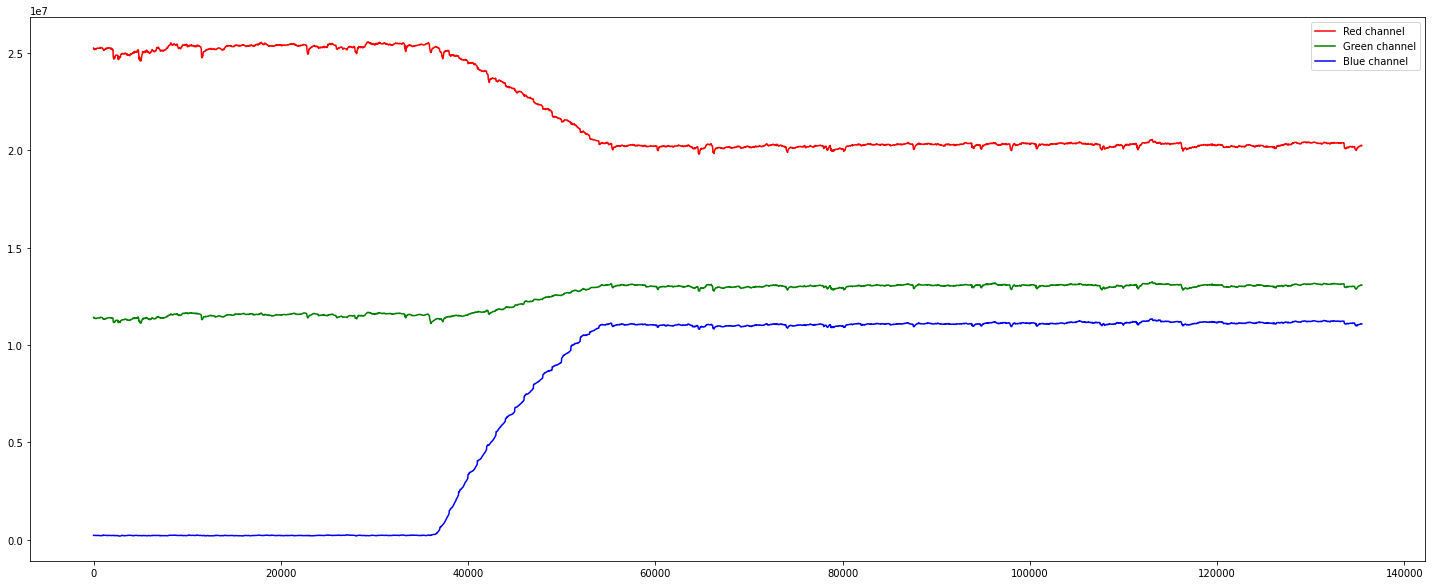

In [65]:
plt.figure(figsize=(25, 10))
plt.plot(df["R"], "r-")
plt.plot(df["G"], "g-")
plt.plot(df["B"], "b-")

plt.legend(["Red channel", "Green channel", "Blue channel"])
plt.show()

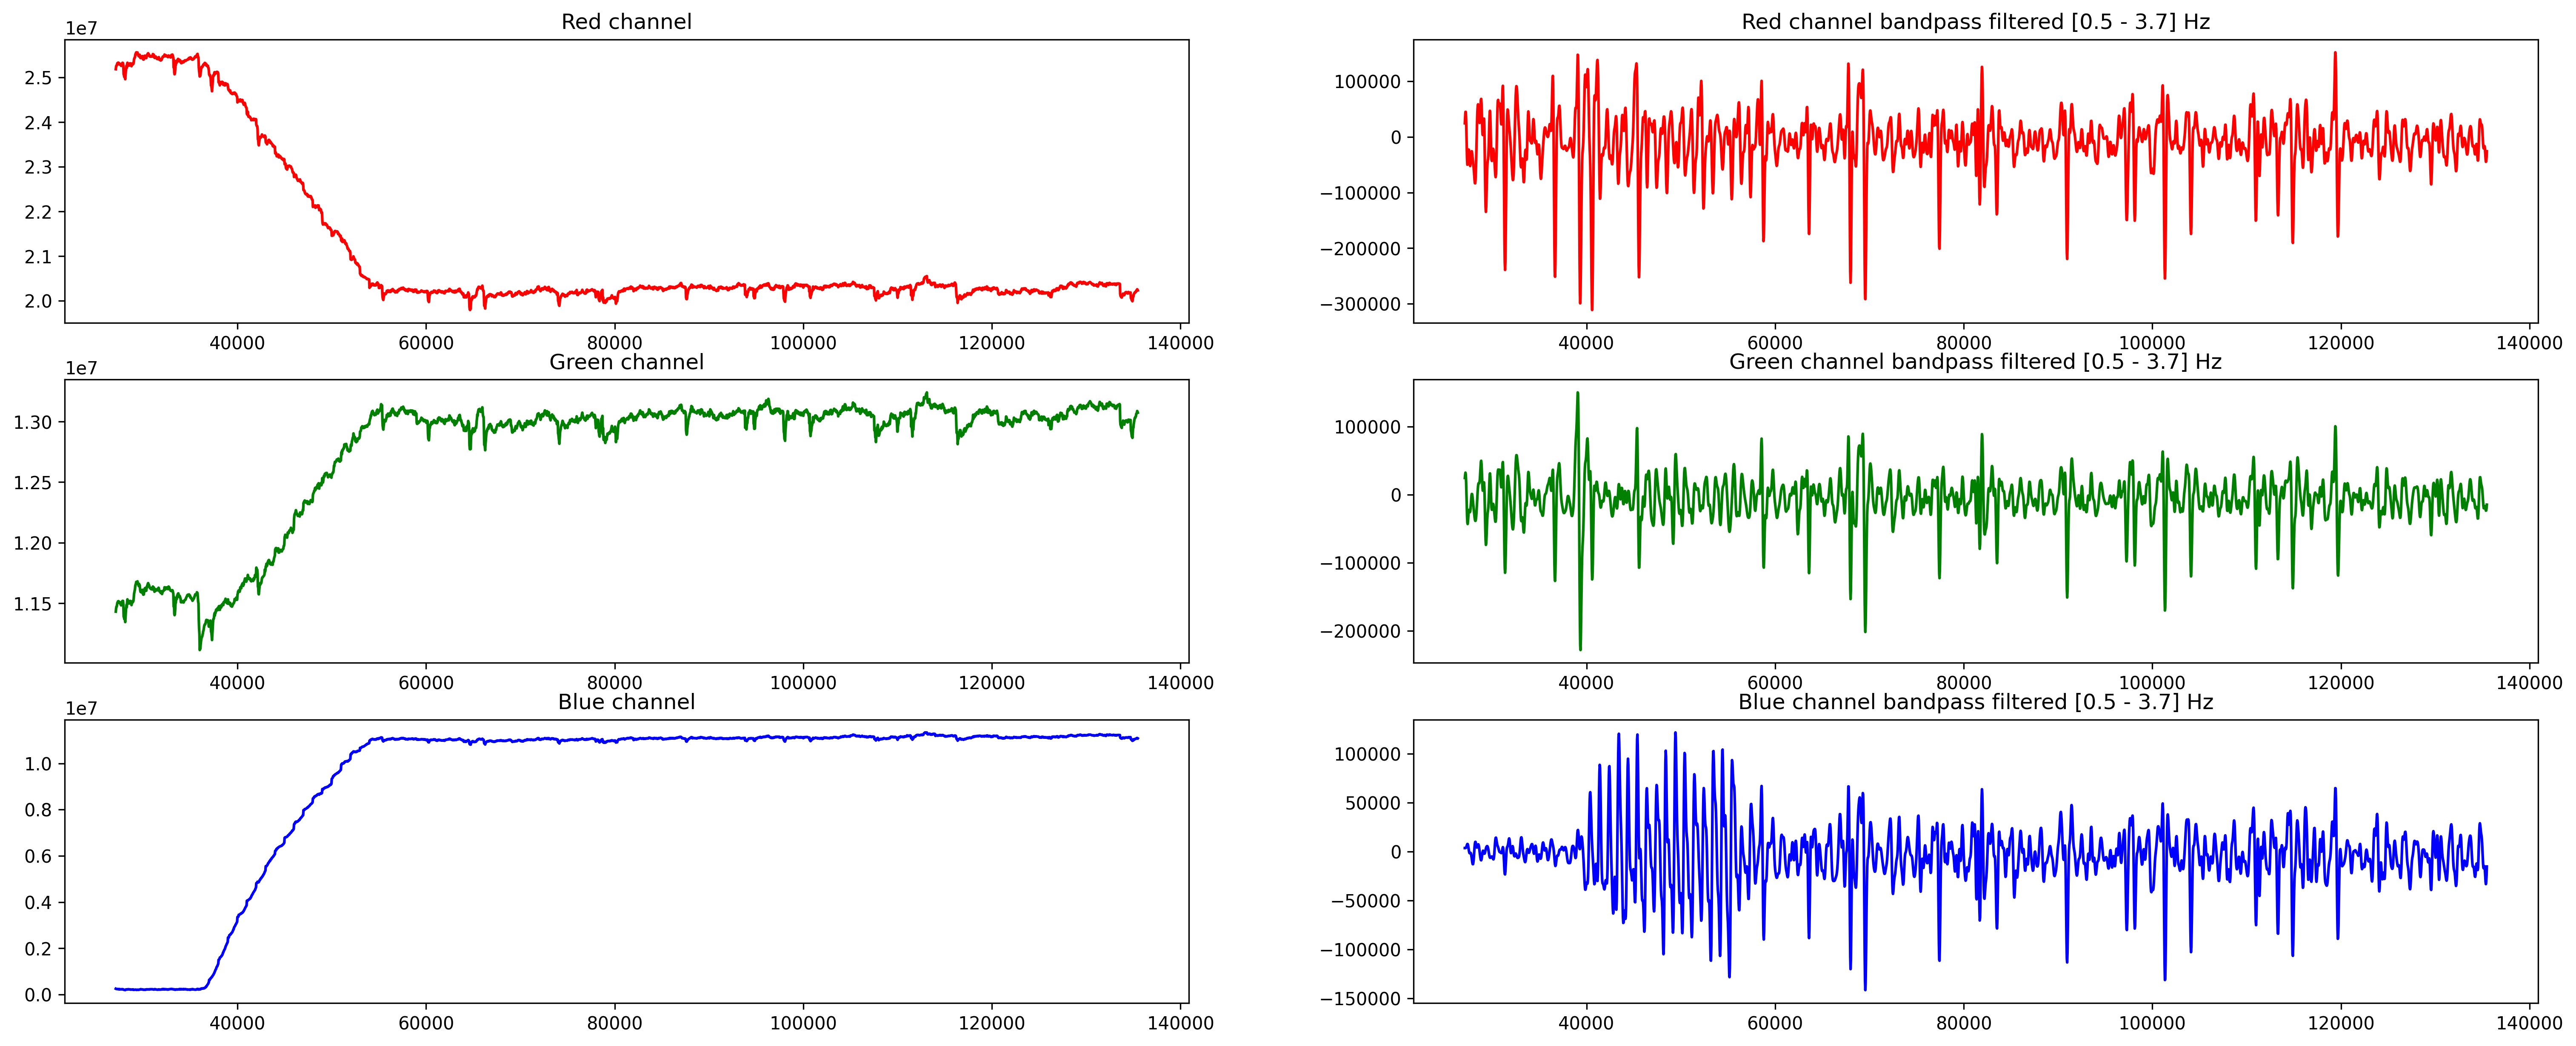

In [119]:
from scipy.fft import fft, fftfreq

F1 = 0.5
F2 = 3.7

fir = signal.firwin(200, [F1, F2], window="hamming", pass_zero=False, fs=30)
ndat = int(len(df["R"]) / 5)

df["R_filtered"] = signal.lfilter(fir, 1.0, list(df["R"]))
df["G_filtered"] = signal.lfilter(fir, 1.0, list(df["G"]))
df["B_filtered"] = signal.lfilter(fir, 1.0, list(df["B"]))

sdf = df.iloc[ndat:]

fig, axs = plt.subplots(3, 2, figsize=(25, 10), dpi=300)
axs[0, 0].plot(sdf["R"], "r-")
axs[0, 0].set_title("Red channel")
axs[0, 1].plot(sdf["R_filtered"], "r-")
axs[0, 1].set_title(f"Red channel bandpass filtered [{F1} - {F2}] Hz")

axs[1, 0].plot(sdf["G"], "g-")
axs[1, 0].set_title("Green channel")
axs[1, 1].plot(sdf["G_filtered"], "g-")
axs[1, 1].set_title(f"Green channel bandpass filtered [{F1} - {F2}] Hz")

axs[2, 0].plot(sdf["B"], "b-")
axs[2, 0].set_title("Blue channel")
axs[2, 1].plot(sdf["B_filtered"], "b-")
axs[2, 1].set_title(f"Blue channel bandpass filtered [{F1} - {F2}] Hz")

plt.show()

C:\Users\Krzysiek\AppData\Local\Temp/ipykernel_21952/519188060.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_filtered["PCA"] = res[:, 0]


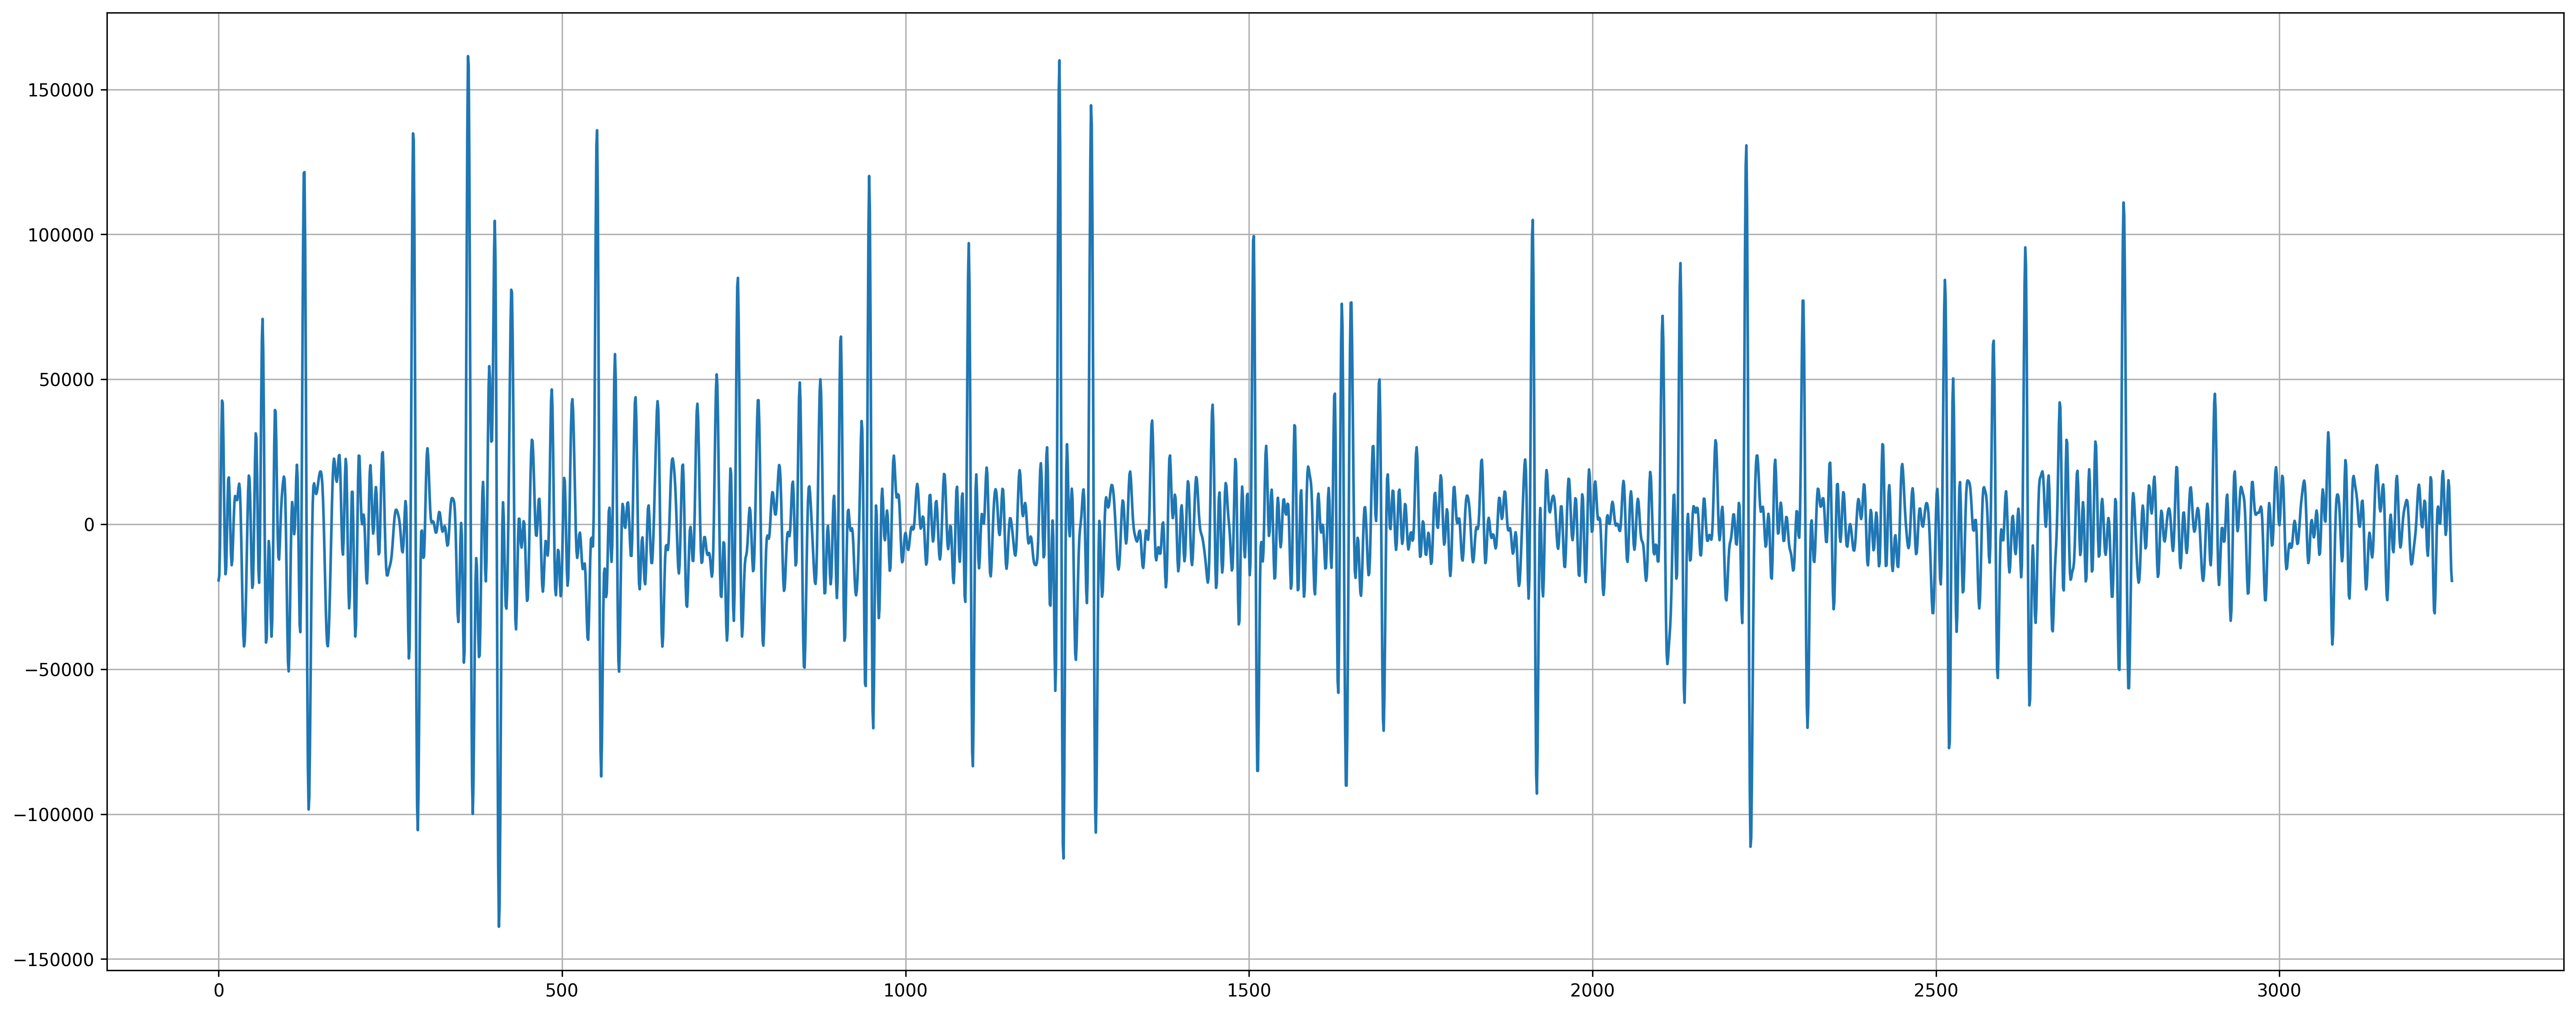

In [141]:
sdf_filtered = sdf[["R_filtered", "R_filtered", "R_filtered"]]

pca = PCA(n_components=3)

res = pca.fit_transform(sdf_filtered)

sdf_filtered["PCA"] = res[:, 0]

plt.figure(figsize=(25, 10), dpi=300)

plt.plot(np.gradient(sdf_filtered["PCA"]))
plt.grid()
plt.show()

In [136]:
def count_passes(l):
    prev_val = None
    count = 0
    for val in l:
        if prev_val is not None:
            if prev_val >= 0 and prev_val > val:
                count += 1
        prev_val = val
    return count

In [142]:
count_passes(list(np.gradient(sdf_filtered["PCA"])))

905

In [140]:
np.gradient(sdf_filtered["PCA"])

array([-19340.29967378, -17643.53443087,  -7955.90328328, ...,
        -6600.69642062, -15909.80491713, -19519.34506629])